[FUENTE DE INFORMACION: Estudio de Conjunto de datos desequilibrados para la detección de fraude con tarjeta de crédito- url: (https://www.kaggle.com/datasets/dark06thunder/credit-card-dataset?select=credit_dataset.csv)](https://www.kaggle.com/datasets/dark06thunder/credit-card-dataset?select=credit_dataset.csv)

<a id='Indice'></a>
## Índice
[Inicio ▲](#Indice)
1. [Estudiando el conjunto de Datos](#estudiando-los-datos)
    1. [Graficando las clases](#grafico-clases)
1. [Aplicando SMOTE](#aplicando-smote)
    1. [Evaluando Resultados - multiparametricos](#resultados-smote)

In [1]:
import pandas as pd 

import smote_variants as sv

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


## Preparacion de los datos

In [2]:
df = pd.read_csv('credit_dataset.csv')

In [3]:
fraudes_detectados = df[df['TARGET'] == 1]
fraudes_detectados

,Unnamed: 0,ID,GENDER,CAR,REALITY,NO_OF_CHILD,INCOME,INCOME_TYPE,EDUCATION_TYPE,FAMILY_TYPE,HOUSE_TYPE,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
508,508,5009628,F,N,N,0,238500.0,Working,Secondary / secondary special,Married,House / apartment,1,1,0,0,2.0,59,53,9,1
664,664,5009938,F,N,Y,2,157500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,4.0,39,29,6,1
956,956,5010535,F,Y,N,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,4.0,52,38,8,1
960,960,5010541,F,Y,N,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,4.0,52,38,8,1
1177,1177,5010864,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,1,3.0,51,50,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25129,25129,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,11,48,7,1
25130,25130,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,2.0,23,34,4,1
25131,25131,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,2.0,32,34,4,1
25132,25132,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,2.0,9,49,2,1


In [4]:
fraudes_detectados.describe()

,Unnamed: 0,ID,NO_OF_CHILD,INCOME,FLAG_MOBIL,WORK_PHONE,PHONE,E_MAIL,FAMILY SIZE,BEGIN_MONTH,AGE,YEARS_EMPLOYED,TARGET
count,422.000000,4.220000e+02,422.000000,422.000000,422.0,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.0
mean,20567.625592,5.085477e+06,0.507109,200056.148104,1.0,0.293839,0.303318,0.101896,2.253555,33.758294,39.959716,5.566351,1.0
std,6990.117451,4.204221e+04,0.791101,102783.038134,0.0,0.456060,0.460237,0.302870,0.972141,15.607823,9.547023,5.196756,0.0
min,508.000000,5.009524e+06,0.000000,36000.000000,1.0,0.000000,0.000000,0.000000,1.000000,2.000000,22.000000,0.000000,1.0
25%,17653.250000,5.051086e+06,0.000000,135000.000000,1.0,0.000000,0.000000,0.000000,2.000000,21.000000,31.000000,2.000000,1.0
50%,24922.500000,5.092006e+06,0.000000,180000.000000,1.0,0.000000,0.000000,0.000000,2.000000,35.000000,40.000000,4.000000,1.0
75%,25027.750000,5.118357e+06,1.000000,247500.000000,1.0,1.000000,1.000000,0.000000,3.000000,47.000000,48.000000,8.000000,1.0
max,25133.000000,5.150337e+06,4.000000,900000.000000,1.0,1.000000,1.000000,1.000000,6.000000,60.000000,62.000000,29.000000,1.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt

index = np.arange(start=0, stop=fraudes_detectados['INCOME'].count()+1)
# print(index)
unicos = fraudes_detectados['INCOME'].rank()
type(unicos)

# ts = pd.Series(fraudes_detectados['INCOME'],index=index)
# ts.plot()
# plt.show()

pandas.core.series.Series

ejemplo de fraude:
- mujer (F)
- sin auto (N)
- sin hijos (0)
- ingreso 238500
- tipo de ingreso: trabajo 
- tipo de educacion: secundario/ secundario especial
- tipo de familia: casada 
- tipo de casa: casa/ apartamento 
- auto: si (1)
- telefono laboral
- tiene email
- tamaño familia: 2
- mes de inicio: 59
- año: 52
- años empleada: 7

In [6]:
df['GENDER'] = [0 if x == 'M' else 1 for x in df['GENDER']]
df['CAR'] = [1 if x == 'Y' else 0 for x in df['CAR']]
df['REALITY'] = [1 if x == 'Y' else 0 for x in df['REALITY']]
dummy_income_type = pd.get_dummies(df['INCOME_TYPE'], prefix='INC_TYPE', drop_first=True)
dummy_edu_type = pd.get_dummies(df['EDUCATION_TYPE'], prefix='EDU_TYPE', drop_first=True)
dummy_family_type = pd.get_dummies(df['FAMILY_TYPE'], prefix='FAM_TYPE', drop_first=True)
dummy_house_type = pd.get_dummies(df['HOUSE_TYPE'], prefix='HOUSE_TYPE', drop_first=True)
to_drop = ['Unnamed: 0', 'ID', 'FLAG_MOBIL', 'INCOME_TYPE',
           'EDUCATION_TYPE', 'FAMILY_TYPE', 'HOUSE_TYPE']
df.drop(to_drop, axis=1, inplace=True)

# Fusionar en un solo Dataframe
merged = pd.concat([df, dummy_income_type, dummy_edu_type, dummy_family_type, dummy_house_type], axis=1)
from sklearn.preprocessing import MinMaxScaler

# Escalar solo columnas que tengan valores mayores que 1
to_scale = [col for col in df.columns if df[col].max() > 1]
mms = MinMaxScaler()
scaled = mms.fit_transform(merged[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# Reemplazar las columnas originales con escalas
for col in scaled:
    merged[col] = scaled[col]
    
merged.head()
data = merged

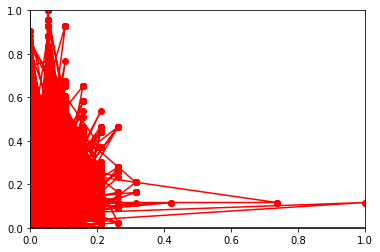

In [7]:
from matplotlib import pyplot

# Valores del eje X que toma el gráfico.
x = data['FAMILY SIZE']
y = data['YEARS_EMPLOYED']
# Graficar ambas funciones.
pyplot.plot(x, y, marker='o', color='red')

pyplot.axhline(0, color="black")
pyplot.axvline(0, color="black")
# Limitar los valores de los ejes.
pyplot.xlim(0, 1)
pyplot.ylim(0, 1)
# Mostrarlo.
pyplot.show()

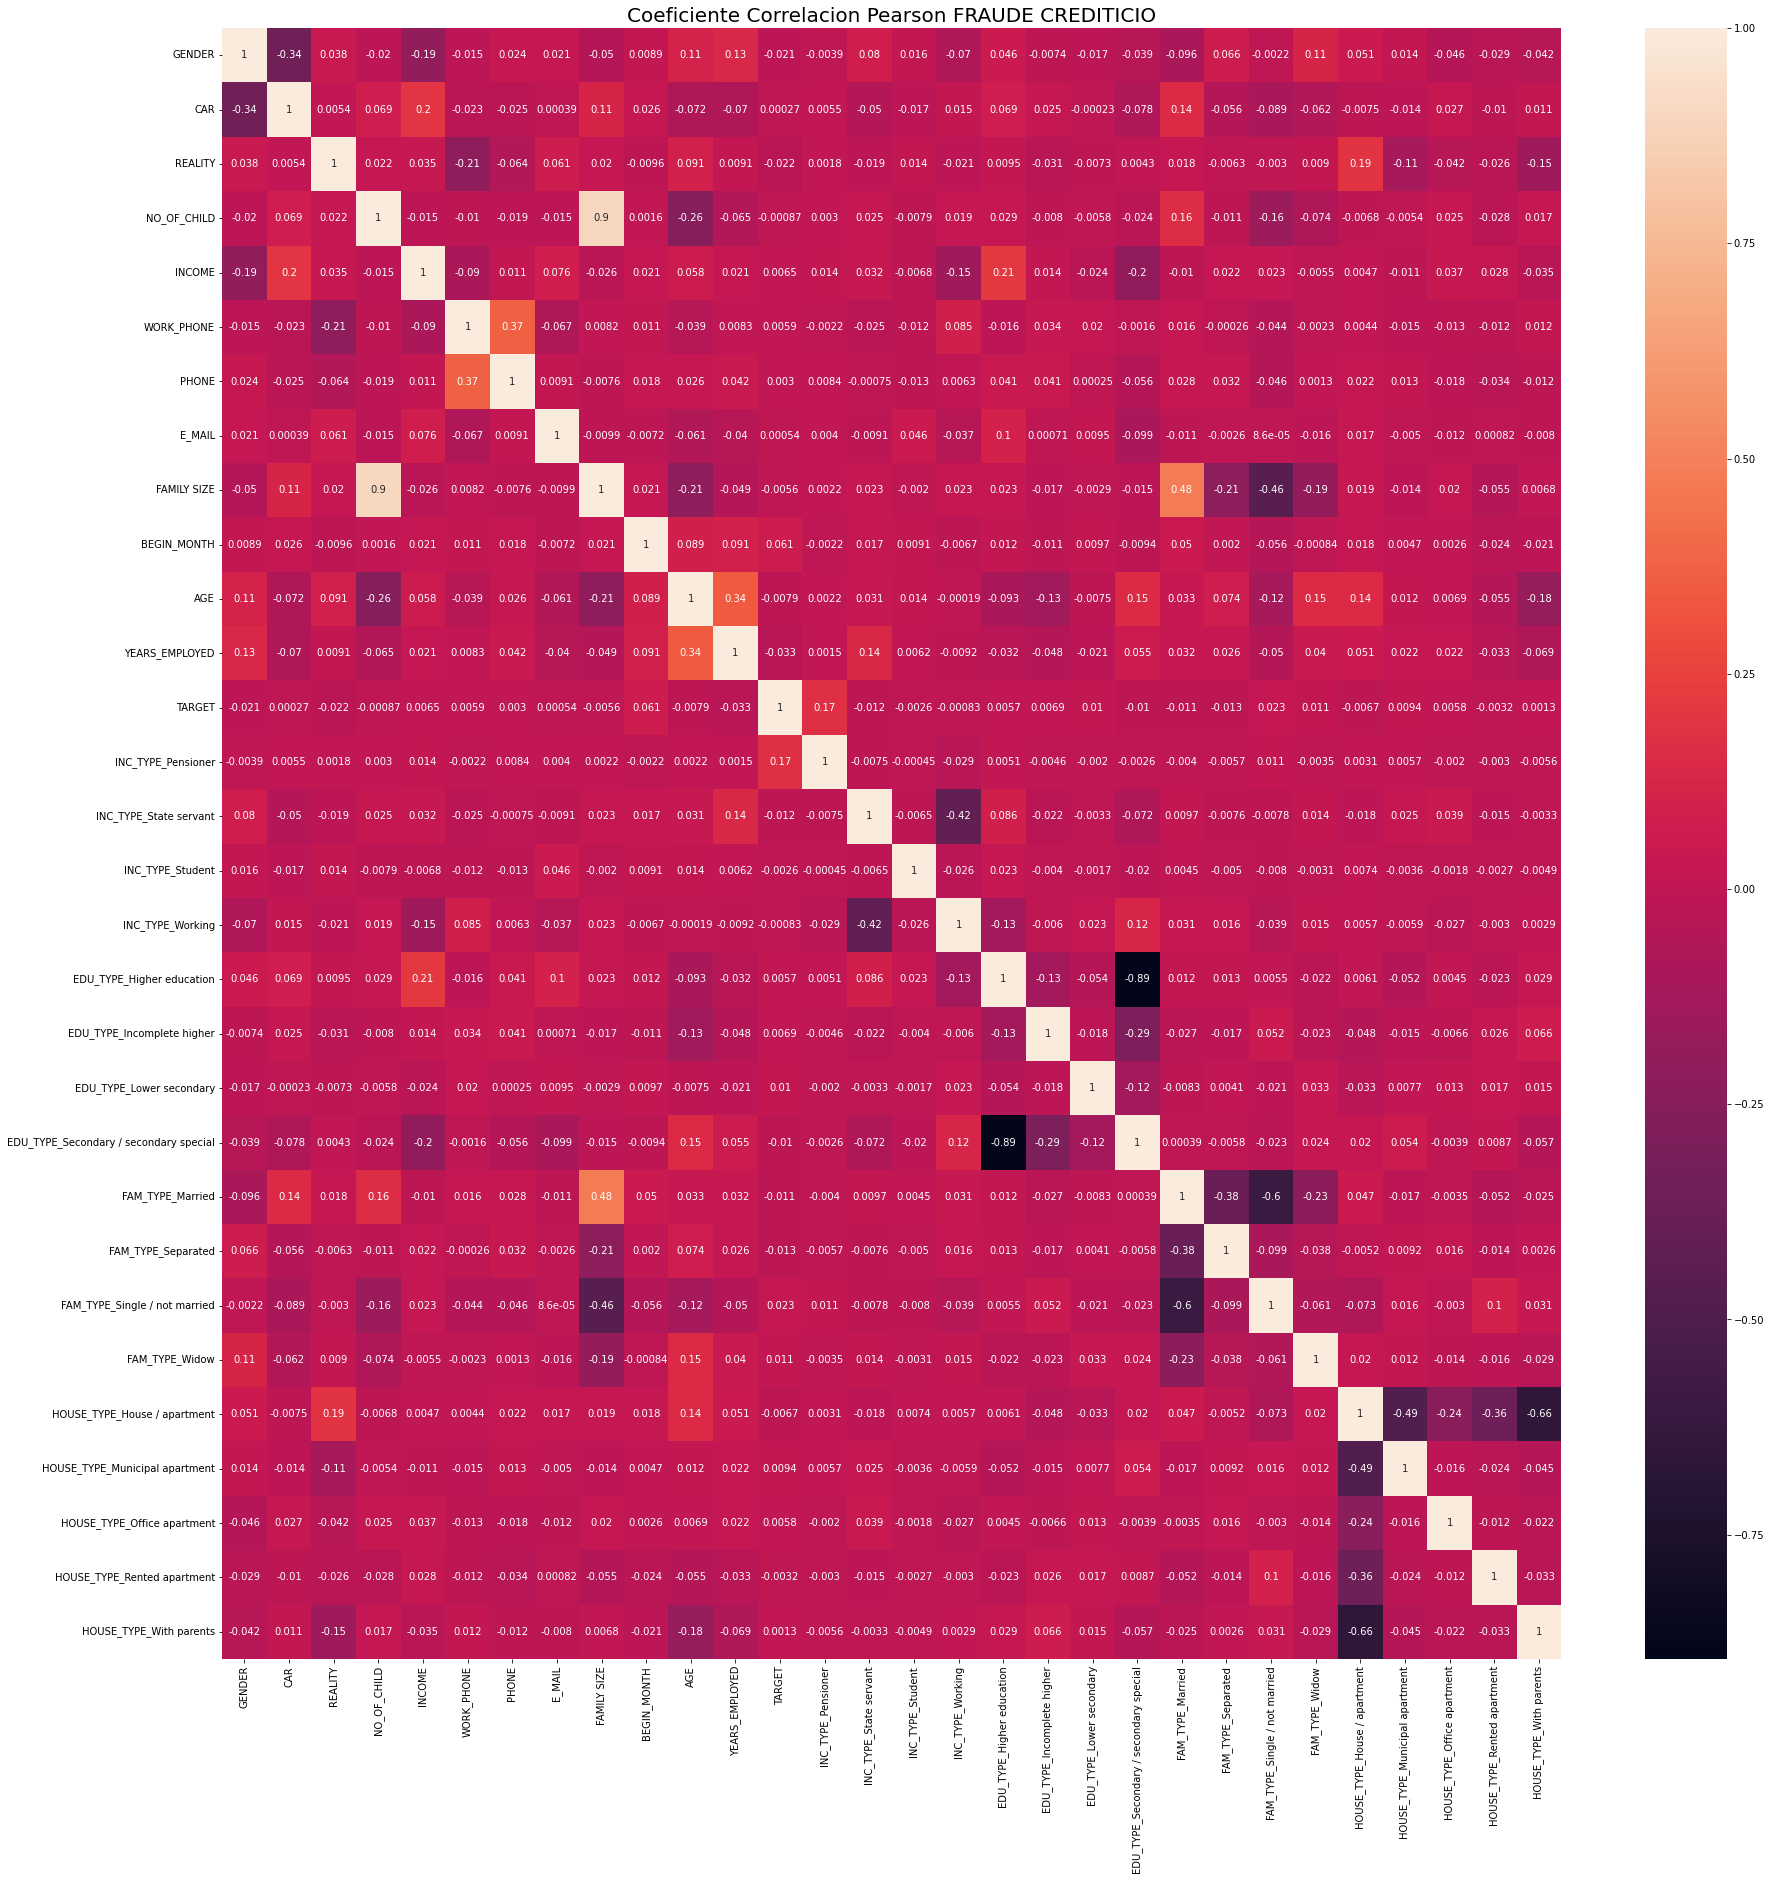

In [8]:
import seaborn as sns

# corr_df = data.corr()
corr_df = data.corr(method='pearson')

plt.figure(figsize=(30, 30))
sns.heatmap(corr_df, annot=True)
plt.title('Coeficiente Correlacion Pearson FRAUDE CREDITICIO', fontsize=20)
plt.show()

In [9]:
data.shape

(25134, 30)

In [10]:
X, y = data.drop(['TARGET'], axis=1), data['TARGET']

<a id='grafico-clases'></a>
## Grafico de Clases
[Inicio ▲](#Indice)

[Text(0, 0, '24712'), Text(0, 0, '422')]

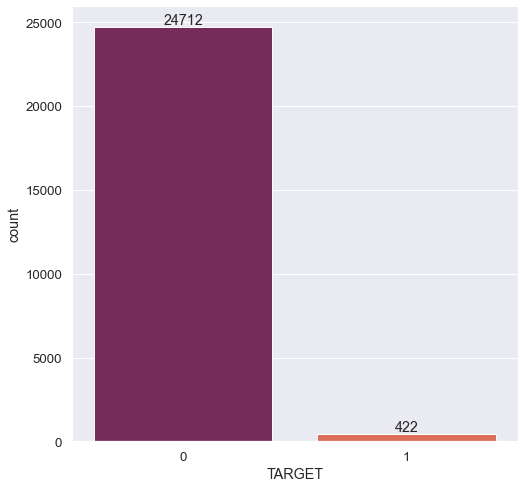

In [11]:
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': [8, 8]}, font_scale=1.2)

ax =  sns.countplot(x='TARGET', data=data, palette='rocket')

abs_values = data['TARGET'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(random_state=42, n_estimators=500)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[8130   21]
 [ 127   17]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8151
           1       0.45      0.12      0.19       144

    accuracy                           0.98      8295
   macro avg       0.72      0.56      0.59      8295
weighted avg       0.98      0.98      0.98      8295



<a id='aplicando-smote'></a>
## Aplicando SMOTE
[Inicio ▲](#Indice)

## Montaje de un pipeline

metricas: https://scikit-learn.org/stable/_sources/modules/model_evaluation.rst.txt

In [36]:
# oversampler= sv.SMOTE()
# oversampler= sv.SMOTE_ENN()
oversampler= sv.SMOTE_TomekLinks()
# oversampler= sv.SMOTE_IPF()
# classifier= GaussianNB()
classifier= RandomForestClassifier(random_state=42, n_estimators=100)
model= Pipeline([
                ('scale', StandardScaler()),
                ('clf', sv.OversamplingClassifier(oversampler, classifier))
            ])
model.fit(X_train, y_train)
param_grid= {'clf__oversampler':[sv.distance_SMOTE(proportion=0.2),
                                 sv.distance_SMOTE(proportion=0.3),
                                 sv.distance_SMOTE(proportion=0.4),
                                 sv.distance_SMOTE(proportion=0.5),
                                 sv.distance_SMOTE(proportion=0.6),
                                 sv.distance_SMOTE(proportion=0.7),
                                 sv.distance_SMOTE(proportion=0.8),
                                 sv.distance_SMOTE(proportion=0.9),
                                 sv.distance_SMOTE(proportion=1.0)]}
param_grid['clf__oversampler']


2022-06-07 23:05:24,589:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-06-07 23:05:24,590:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Users\\\\FamiliaNatelloMedina\\\\AppData\\\\Roaming\\\\Python\\\\Python310\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-06-07 23:05:25,022:INFO:TomekLinkRemoval: Running noise removal via TomekLinkRemoval


In [37]:
scoring = {"recall": "recall", "precision": "precision", "f1" : "f1"}
grid= GridSearchCV(model, param_grid= param_grid, cv= 3, n_jobs= 1, verbose= 2, scoring= scoring, refit='recall' ) #probar con lista ['f1','recall','precision']
grid.fit(X_train, y_train)

2022-06-07 23:05:47,395:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


Fitting 3 folds for each of 9 candidates, totalling 27 fits


2022-06-07 23:05:49,146:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.6s


2022-06-07 23:05:50,946:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.7s


2022-06-07 23:05:52,682:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.6s


2022-06-07 23:05:54,432:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.6s


2022-06-07 23:05:56,412:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:05:58,212:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.3, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.7s


2022-06-07 23:06:00,185:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:06:02,565:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.3s


2022-06-07 23:06:04,615:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.4, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:06:06,588:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:06:08,572:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:06:10,548:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:06:12,728:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.1s


2022-06-07 23:06:14,909:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.1s


2022-06-07 23:06:16,879:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.6, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   1.9s


2022-06-07 23:06:18,932:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.0s


2022-06-07 23:06:21,073:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.0s


2022-06-07 23:06:23,175:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.0s


2022-06-07 23:06:25,389:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.1s


2022-06-07 23:06:27,703:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.2s


2022-06-07 23:06:29,939:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.1s


2022-06-07 23:06:32,245:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.2s


2022-06-07 23:06:34,569:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.2s


2022-06-07 23:06:36,924:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 0.9, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.3s


2022-06-07 23:06:39,334:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.3s


2022-06-07 23:06:41,742:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.3s


2022-06-07 23:06:44,210:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.8, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


[CV] END clf__oversampler=('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}"); total time=   2.4s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        OversamplingClassifier(classifier=RandomForestClassifier(random_state=42),
                                                               oversampler=<smote_variants._smote_variants.SMOTE_TomekLinks object at 0x0000024D78D38160>))]),
             n_jobs=1,
             param_grid={'clf__oversampler': [<smote_variants._smote_variants.distance_SMOTE object at 0x0000024D7...
                                              <smote_variants._smote_variants.distance_SMOTE object at 0x0000024D74C462C0>]},
             refit='recall',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'},
             verbose=2)

<a id='resultados-smote'></a>
## Evaluando los resultados de SMOTE
[Inicio ▲](#Indice)

In [38]:
datos = {'Recall' : grid.cv_results_['mean_test_recall'],
         'Precision' : grid.cv_results_['mean_test_precision'],
         'F1' : grid.cv_results_['mean_test_f1']}

df = pd.DataFrame(datos)

print(grid.get_params)
print(df)

predicciones = grid.best_estimator_.predict(X_test)

print(predicciones)

print('PUNTAJE MEJOR ESTIMADOR: ' , grid.best_estimator_.score(X_test, y_test))

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('clf',
                                        OversamplingClassifier(classifier=RandomForestClassifier(random_state=42),
                                                               oversampler=<smote_variants._smote_variants.SMOTE_TomekLinks object at 0x0000024D78D38160>))]),
             n_jobs=1,
             param_grid={'clf__oversampler': [<smote_variants._smote_variants.distance_SMOTE object at 0x0000024D7...
                                              <smote_variants._smote_variants.distance_SMOTE object at 0x0000024D74C462C0>]},
             refit='recall',
             scoring={'f1': 'f1', 'precision': 'precision', 'recall': 'recall'},
             verbose=2)>
     Recall  Precision        F1
0  0.894528   0.980661  0.935577
1  0.898803   0.980775  0.937957
2  0.901369   0.980818  0.939372
3  0.898804   0.

In [16]:
import numpy as np

In [17]:
y_sinSmote = y.to_numpy()
print('majority class: %d' % np.sum(y_sinSmote == 0))
print('minority class: %d' % np.sum(y_sinSmote == 1))

majority class: 24712
minority class: 422


In [18]:
oversampler= sv.SMOTE(proportion=0.7)
X_samp, y_samp= oversampler.sample(X.to_numpy(), y.to_numpy())

2022-06-07 23:00:32,794:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")


In [19]:
print('majority class: %d' % np.sum(y_samp == 0))
print('minority class: %d' % np.sum(y_samp == 1))
dfSmote = pd.DataFrame(X_samp)
dfSmote = dfSmote.assign(col_class = y_samp)
dfSmote

majority class: 24712
minority class: 17425


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,col_class
0,0.0,1.0,1.000000,0.000000,0.055233,0.000000,0.0,0.0,0.052632,0.483333,...,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,1.0,0.0,1.000000,0.000000,0.156977,0.000000,1.0,1.0,0.000000,0.066667,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,1.0,0.0,1.000000,0.000000,0.156977,0.000000,1.0,1.0,0.000000,0.433333,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,1.0,0.0,1.000000,0.000000,0.156977,0.000000,1.0,1.0,0.000000,0.433333,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,1.0,0.0,1.000000,0.000000,0.156977,0.000000,1.0,1.0,0.000000,0.633333,...,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42132,1.0,1.0,0.000000,0.105263,0.069767,0.000000,0.0,0.0,0.157895,0.515657,...,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
42133,0.0,1.0,0.000000,0.103176,0.070494,1.000000,1.0,0.0,0.155808,0.651982,...,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
42134,0.0,0.0,0.271863,0.000000,0.131858,1.000000,1.0,0.0,0.052632,0.681717,...,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
42135,1.0,1.0,0.000000,0.113894,0.069767,0.163993,0.0,0.0,0.166526,0.874866,...,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


Text(0.5, 1.0, 'SMOTE con proportion = 0.7')

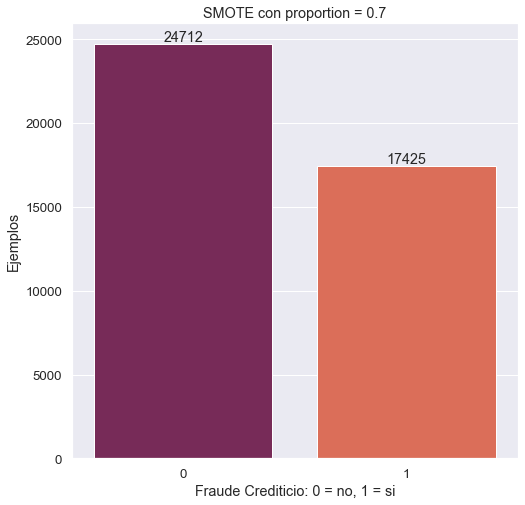

In [20]:
ax =  sns.countplot(x='col_class', data=dfSmote, palette='rocket')

abs_values = dfSmote['col_class'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = no, 1 = si')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('SMOTE con proportion = 0.7')

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X_samp, y_samp, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(random_state=42, n_estimators=500)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[8072   55]
 [ 122 5657]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8127
           1       0.99      0.98      0.98      5779

    accuracy                           0.99     13906
   macro avg       0.99      0.99      0.99     13906
weighted avg       0.99      0.99      0.99     13906



Text(48.5, 0.5, 'true')

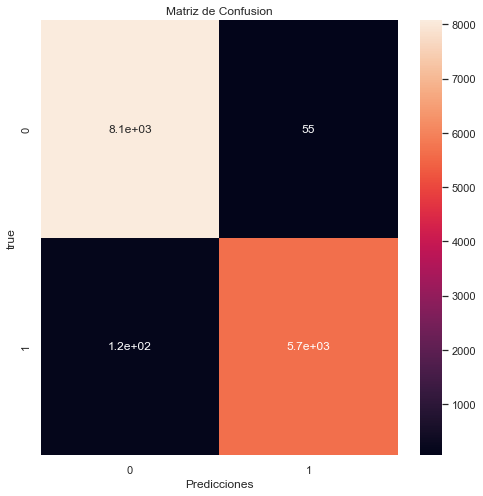

In [22]:
import matplotlib.pyplot as plt

sns.set()
f,ax=plt.subplots()
sns.heatmap(cm,annot=True,ax=ax) #Dibuja un mapa de calor

ax.set_title('Matriz de Confusion') #título
ax.set_xlabel('Predicciones') #eje x
ax.set_ylabel('true') #eje y

<a id='smote-ipf-proportion0.7'></a>
## SMOTE IPF con proportion modificado
[Inicio ▲](#Indice)

In [23]:
oversampler_ipf= sv.SMOTE_IPF(proportion=0.7)
X_ipf, y_ipf= oversampler_ipf.sample(X.to_numpy(), y.to_numpy())

2022-06-07 23:00:47,692:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 0.7, 'n_neighbors': 5, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': DecisionTreeClassifier(random_state=2), 'random_state': None}")
2022-06-07 23:00:47,695:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.7, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Users\\\\FamiliaNatelloMedina\\\\AppData\\\\Roaming\\\\Python\\\\Python310\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-06-07 23:00:49,721:INFO:SMOTE_IPF: Removing 43 elements
2022-06-07 23:00:51,761:INFO:SMOTE_IPF: Removing 0 elements
2022-06-07 23:00:53,859:INFO:SMOTE_IPF: Removing 0 elements


In [24]:
print('majority class: %d' % np.sum(y_ipf == 0))
print('minority class: %d' % np.sum(y_ipf == 1))

majority class: 24704
minority class: 17390


Text(0.5, 1.0, 'SMOTE IPF con proportion = 0.7')

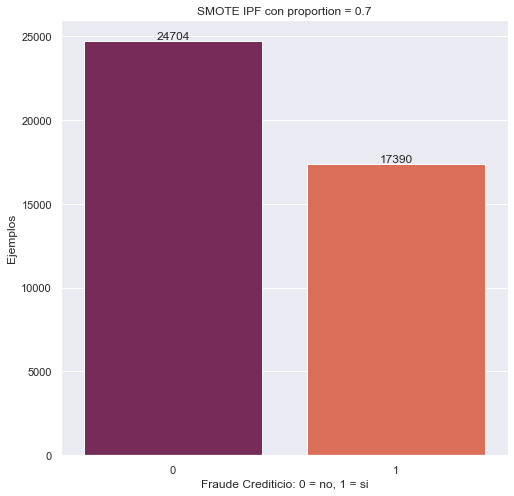

In [25]:
dfSmoteIPF = pd.DataFrame(X_ipf)
dfSmoteIPF = dfSmoteIPF.assign(col_class = y_ipf)
dfSmoteIPF
ax =  sns.countplot(x='col_class', data=dfSmoteIPF, palette='rocket')

abs_values = dfSmoteIPF['col_class'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = no, 1 = si')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('SMOTE IPF con proportion = 0.7')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_ipf, y_ipf, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(random_state=42, n_estimators=500)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[8158   34]
 [ 105 5595]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8192
           1       0.99      0.98      0.99      5700

    accuracy                           0.99     13892
   macro avg       0.99      0.99      0.99     13892
weighted avg       0.99      0.99      0.99     13892



<a id='smote-enn-proportion0.7'></a>
## SMOTE ENN con proportion modificado
[Inicio ▲](#Indice)

In [27]:
oversampler_enn= sv.SMOTE_ENN(proportion=0.5)
X_enn, y_enn= oversampler_enn.sample(X.to_numpy(), y.to_numpy())
print('majority class: %d' % np.sum(y_enn == 0))
print('minority class: %d' % np.sum(y_enn == 1))

2022-06-07 23:01:08,027:INFO:SMOTE_ENN: Running sampling via ('SMOTE_ENN', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-06-07 23:01:08,040:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.5, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Users\\\\FamiliaNatelloMedina\\\\AppData\\\\Roaming\\\\Python\\\\Python310\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-06-07 23:01:08,100:INFO:EditedNearestNeighbors: Running noise removal via EditedNearestNeighbors


majority class: 23795
minority class: 12478


Text(0.5, 1.0, 'SMOTE ENN con proportion = 0.5')

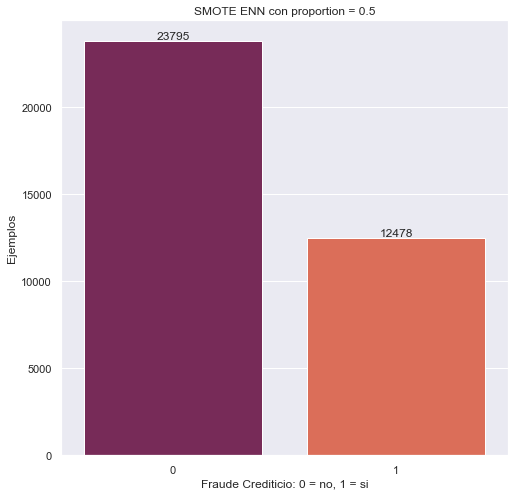

In [28]:
dfSmoteENN = pd.DataFrame(X_enn)
dfSmoteENN = dfSmoteENN.assign(col_class = y_enn)
dfSmoteENN
ax =  sns.countplot(x='col_class', data=dfSmoteENN, palette='rocket')

abs_values = dfSmoteENN['col_class'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = no, 1 = si')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('SMOTE ENN con proportion = 0.5')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_enn, y_enn, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(max_depth=3, random_state=0, n_estimators=800)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[7834    0]
 [3534  603]]
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      7834
           1       1.00      0.15      0.25      4137

    accuracy                           0.70     11971
   macro avg       0.84      0.57      0.54     11971
weighted avg       0.80      0.70      0.62     11971



<a id='smote-tomekLinks-proportion0.7'></a>
## SMOTE TOMEKLinks con proportion modificado
[Inicio ▲](#Indice)

In [30]:
oversampler_klinks= sv.SMOTE_TomekLinks(proportion=0.2)
X_tklinks, y_tklinks= oversampler_klinks.sample(X.to_numpy(), y.to_numpy())
print('majority class: %d' % np.sum(y_tklinks == 0))
print('minority class: %d' % np.sum(y_tklinks == 1))

2022-06-07 23:01:42,227:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': None}")
2022-06-07 23:01:42,235:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 0.2, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': <module 'numpy.random' from 'C:\\\\Users\\\\FamiliaNatelloMedina\\\\AppData\\\\Roaming\\\\Python\\\\Python310\\\\site-packages\\\\numpy\\\\random\\\\__init__.py'>}")
2022-06-07 23:01:42,276:INFO:TomekLinkRemoval: Running noise removal via TomekLinkRemoval


majority class: 24630
minority class: 5198


Text(0.5, 1.0, 'SMOTE TomeK-Links con proportion = 0.2')

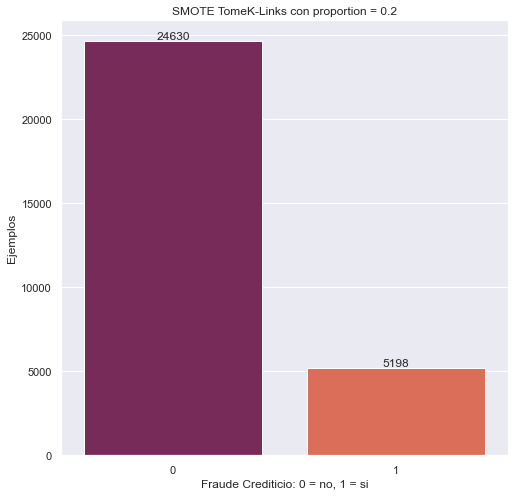

In [31]:
dfSmoteTKLinks = pd.DataFrame(X_tklinks)
dfSmoteTKLinks = dfSmoteTKLinks.assign(col_class = y_tklinks)
dfSmoteTKLinks
ax =  sns.countplot(x='col_class', data=dfSmoteTKLinks, palette='rocket')

abs_values = dfSmoteTKLinks['col_class'].value_counts(ascending=False).values

ax.set_ylabel('Ejemplos')
ax.set_xlabel('Fraude Crediticio: 0 = no, 1 = si')
ax.bar_label(container=ax.containers[0], labels=abs_values)
ax.set_title('SMOTE TomeK-Links con proportion = 0.2')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_tklinks, y_tklinks, test_size= 0.33, random_state=42)
clasifier = RandomForestClassifier(max_depth=3, random_state=0)

# fit the model

clasifier.fit(X_train,y_train)
y_pred=clasifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)
print(classification_report(y_test, y_pred))

Confusion matrix

 [[8154    0]
 [1669   21]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      8154
           1       1.00      0.01      0.02      1690

    accuracy                           0.83      9844
   macro avg       0.92      0.51      0.47      9844
weighted avg       0.86      0.83      0.76      9844

